# <center> 🎩✨ Продвинутый feature engeneering </center>

<img src='https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/images/cbemb.png'>
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">🛠 Модифицируем MLP на pytorch с двумя головами.  </a></li>

<li><a href="#c2">👩🏾‍🚀 Добываем эмбеддинги</a></li>
<li><a href="#с3">📲 Эмбеддинги + CatBoost </a>
<li><a href="#c4">🧠 Мысли и выводы</a>

</li></ul></font></p>

<div class="alert alert-info">

В этом уроке разберём как вытащить эмбеддинги из нейронки и подать их в бустинг. <br>
И узнаем сможет ли такой подход побить скор самой нейронки?

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

In [2]:
# Загружаем train-датасет который мы сохранили на шаге quickstart
data_root = "https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/"
rides_info = pd.read_csv(data_root + 'quickstart_train.csv')
rides_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [3]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

In [4]:
# закодируем категориальные фичи в one hot encoding вектора
rides_info = pd.get_dummies(rides_info, columns=cat_cols)

In [5]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

<ipython-input-5-80a5bdd1c91e>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rides_info.fillna(rides_info.median(), inplace=True)


# <center>🛠 Модифицируем MLP на pytorch с двумя головами.</center>
Возьмем реализацию MLP с двумя головами на PyTorch из предыдущего ноутбука и модифицируем её.

In [6]:
# переведем строковые значения категориального таргета в целочисленные
le = LabelEncoder()
rides_info['target_class'] = le.fit_transform(rides_info['target_class'])

In [7]:
# числовые переменные, которые подвергнем трансформации
num_cols = [col for col in list(rides_info.columns) if col not in drop_cols]

In [8]:
# для нормализации данных используем robust scaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()

target = target_scaler.fit_transform(rides_info['target_reg'].values.reshape(-1, 1))
df['target_reg'] = target
df['target_class'] = rides_info['target_class']

In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import os
import copy

In [11]:
# для наших данных и размера нейросети подойдет запуск на cpu
device = torch.device('cpu')

In [12]:
# ВАЖНО! - фиксируем воспроизводимость
def seed_everything(seed=42):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

In [13]:
# можно попробовать поэкспериментировать с параметрами
class CFG:
    hidden_size=128
    dropout=0.1
    lr=1e-3
    batch_size=128
    num_workers=4
    epochs=20
    num_features=train.shape[1]-2 # кол-во фичей подаваемое на вход
    num_tar_2=train.target_class.nunique() # количество выходов равно кол-ву предсказываемых классов

In [14]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]

        data = row.drop(labels=['target_reg', 'target_class'])

        data = torch.FloatTensor(data.values.astype('float'))
        tar_1 = torch.tensor(row['target_reg']).float()
        tar_2 = row['target_class'].astype('int')

        return data, tar_1, tar_2

In [15]:
# проверим корректность работы методов нашего класса
next(iter(Rides(train)))

(tensor([-0.7302, -1.5000, -1.4019,  1.0000,  0.2215, -0.1615, -0.1000,  0.4241,
         -0.2246,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]),
 tensor(-0.6091),
 2)

In [16]:
dataset = Rides(df)
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=CFG.batch_size,
                                        shuffle=False,
                                        num_workers=CFG.num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
# Построим архитектуру mlp с двумя головами для регрессии и классифкации

class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(cfg.num_features, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size // 2),
                          )

        self.regressor = nn.Sequential(
            nn.Linear(cfg.hidden_size//2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size//2, cfg.num_tar_2)
        )

    def forward(self, data):
        x = self.mlp(data) # здесь эмбеддинги
        tar1 = self.regressor(x) # здесь предсказания
        tar2 = self.classifier(x)
        return x  # оставляем только выход с линейных слоев - эмбеддинги

## Возмем сохраненные веса модели из предыдущего ноутбука и модифицируем архитектуру нейросети для извлечения эмбеддингов.

In [18]:
! wget 'https://raw.githubusercontent.com/Ivanich-spb/CDScourse_tasks/main/data/tab_model.pth'

--2023-07-28 22:28:19--  https://raw.githubusercontent.com/Ivanich-spb/CDScourse_tasks/main/data/tab_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127583 (125K) [application/octet-stream]
Saving to: ‘tab_model.pth’

tab_model.pth       100%[===================>] 124.59K  --.-KB/s    in 0.009s  

2023-07-28 22:28:19 (14.2 MB/s) - ‘tab_model.pth’ saved [127583/127583]



In [19]:
# Загружаем сохранённые ранее веса модели
model = TabularNN(CFG)

PATH = 'tab_model.pth'

#model.load_state_dict(torch.load(PATH))
model.load_state_dict(torch.load(PATH))

# Обычно для получения эмбеддингов финальные слои заменяют на nn.Identity()
# В нашем случае это делать не обязательно
model.classifier = torch.nn.Identity()
model.regressor = torch.nn.Identity()
model.to(device)
model.eval()

TabularNN(
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (regressor): Identity()
  (classifier): Identity()
)

# <center> 👩🏾‍🚀 Добываем эмбеддинги. </center>

In [20]:
# Собираем эмбеддинги в список
embeddings = []

with torch.no_grad():
    for inputs, labels_1, labels_2 in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        embeddings.extend(outputs.detach().cpu().numpy())

In [21]:
# Преобразуем list в датафрейм с эмбеддингами
embed_df = pd.DataFrame(data=embeddings,
                        columns=[f'embed_{i}' for i in range(embeddings[0].shape[0])])
embed_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,0.056628,1.246767,1.181152,-1.209821,0.123670,0.244163,-0.862971,-1.949132,0.778794,1.728167,...,-0.541330,-2.790260,0.810520,-1.586735,-2.586277,2.158148,0.386134,-0.491249,0.848337,0.182023
1,0.835212,4.303697,0.964674,-1.791926,-0.984807,-1.614033,1.483643,-2.679068,0.220737,-0.245258,...,-1.451482,-4.348349,-2.805619,-2.412993,-4.019830,1.431870,0.368517,-1.469993,1.838033,-0.156069
2,1.160743,-3.241346,-2.581707,3.780993,1.381076,4.016422,-0.382286,2.155800,-0.022020,2.126306,...,3.218655,3.774630,5.323013,4.989943,2.240500,-0.051729,-1.036832,4.124353,0.075091,-2.556295
3,1.266282,3.601078,-0.213037,0.444951,-1.225675,-1.274248,2.305374,-1.840529,-0.231383,-0.998590,...,-1.492174,-3.103134,-1.947124,-1.758919,-2.400137,0.712355,-0.330813,0.453636,2.884669,-0.750332
4,0.910321,4.764591,1.225840,-1.425087,-1.410564,-2.116340,2.003392,-3.003037,0.044556,-0.915410,...,-2.256801,-5.051937,-3.200010,-3.450076,-3.888075,1.328032,0.289427,-1.470748,2.361770,0.020122


## <center> 📲 Эмбеддинги + `CatBoost` </center>
Добавим эмбеддинги к нашему датасету и попробуем обучить бустинг.

In [22]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.8 MB/s eta 0:00:00


In [23]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [24]:
# Присоединяем эмбединги к трэйн датасету
df = pd.concat((df, embed_df) ,axis=1)
df.head()

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,-0.460317,0.5,0.258414,0.75,0.567305,-0.187985,0.0,0.129562,0.019027,0.0,...,-0.541330,-2.790260,0.810520,-1.586735,-2.586277,2.158148,0.386134,-0.491249,0.848337,0.182023
1,-0.365079,0.5,0.303616,0.75,0.072227,0.841243,-0.1,0.237381,1.085987,0.0,...,-1.451482,-4.348349,-2.805619,-2.412993,-4.019830,1.431870,0.368517,-1.469993,1.838033,-0.156069
2,1.539683,-1.0,-0.903502,-0.25,0.626258,0.465096,0.0,-1.077932,0.235335,0.0,...,3.218655,3.774630,5.323013,4.989943,2.240500,-0.051729,-1.036832,4.124353,0.075091,-2.556295
3,-0.253968,-1.5,-1.389116,0.50,-1.081739,0.575940,0.0,0.005501,-0.419877,0.0,...,-1.492174,-3.103134,-1.947124,-1.758919,-2.400137,0.712355,-0.330813,0.453636,2.884669,-0.750332
4,0.269841,-1.0,-0.835577,-0.25,-0.503927,0.133441,0.0,0.477418,-1.221735,0.0,...,-2.256801,-5.051937,-3.200010,-3.450076,-3.888075,1.328032,0.289427,-1.470748,2.361770,0.020122


In [25]:
X = df.drop(['target_reg','target_class'], axis=1)
y = df['target_class']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True)

In [28]:
clf.fit( X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(clf.get_best_score())

Learning rate set to 0.109335
0:	learn: 1.7851393	test: 1.8031023	best: 1.8031023 (0)	total: 234ms	remaining: 3m 53s
50:	learn: 0.4026442	test: 0.5877700	best: 0.5877352 (49)	total: 10.1s	remaining: 3m 8s
100:	learn: 0.3230974	test: 0.5779766	best: 0.5756181 (90)	total: 24s	remaining: 3m 33s
150:	learn: 0.2691321	test: 0.5786565	best: 0.5756181 (90)	total: 38.4s	remaining: 3m 35s
200:	learn: 0.2241917	test: 0.5857836	best: 0.5756181 (90)	total: 46.5s	remaining: 3m 4s
250:	learn: 0.1891954	test: 0.5925978	best: 0.5756181 (90)	total: 53.9s	remaining: 2m 40s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5756180785
bestIteration = 90

Shrink model to first 91 iterations.
{'learn': {'MultiClass': 0.16818548788885485}, 'validation': {'MultiClass': 0.5756180785499907}}


In [29]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:30]

,Feature Id,Importances
0,rating_min,17.195175
1,embed_17,8.286127
2,embed_61,6.947302
3,embed_52,4.847196
4,embed_58,4.779745
5,embed_63,4.442089
6,embed_40,3.924660
7,embed_6,3.084473
8,embed_37,2.515497
9,embed_38,1.894114


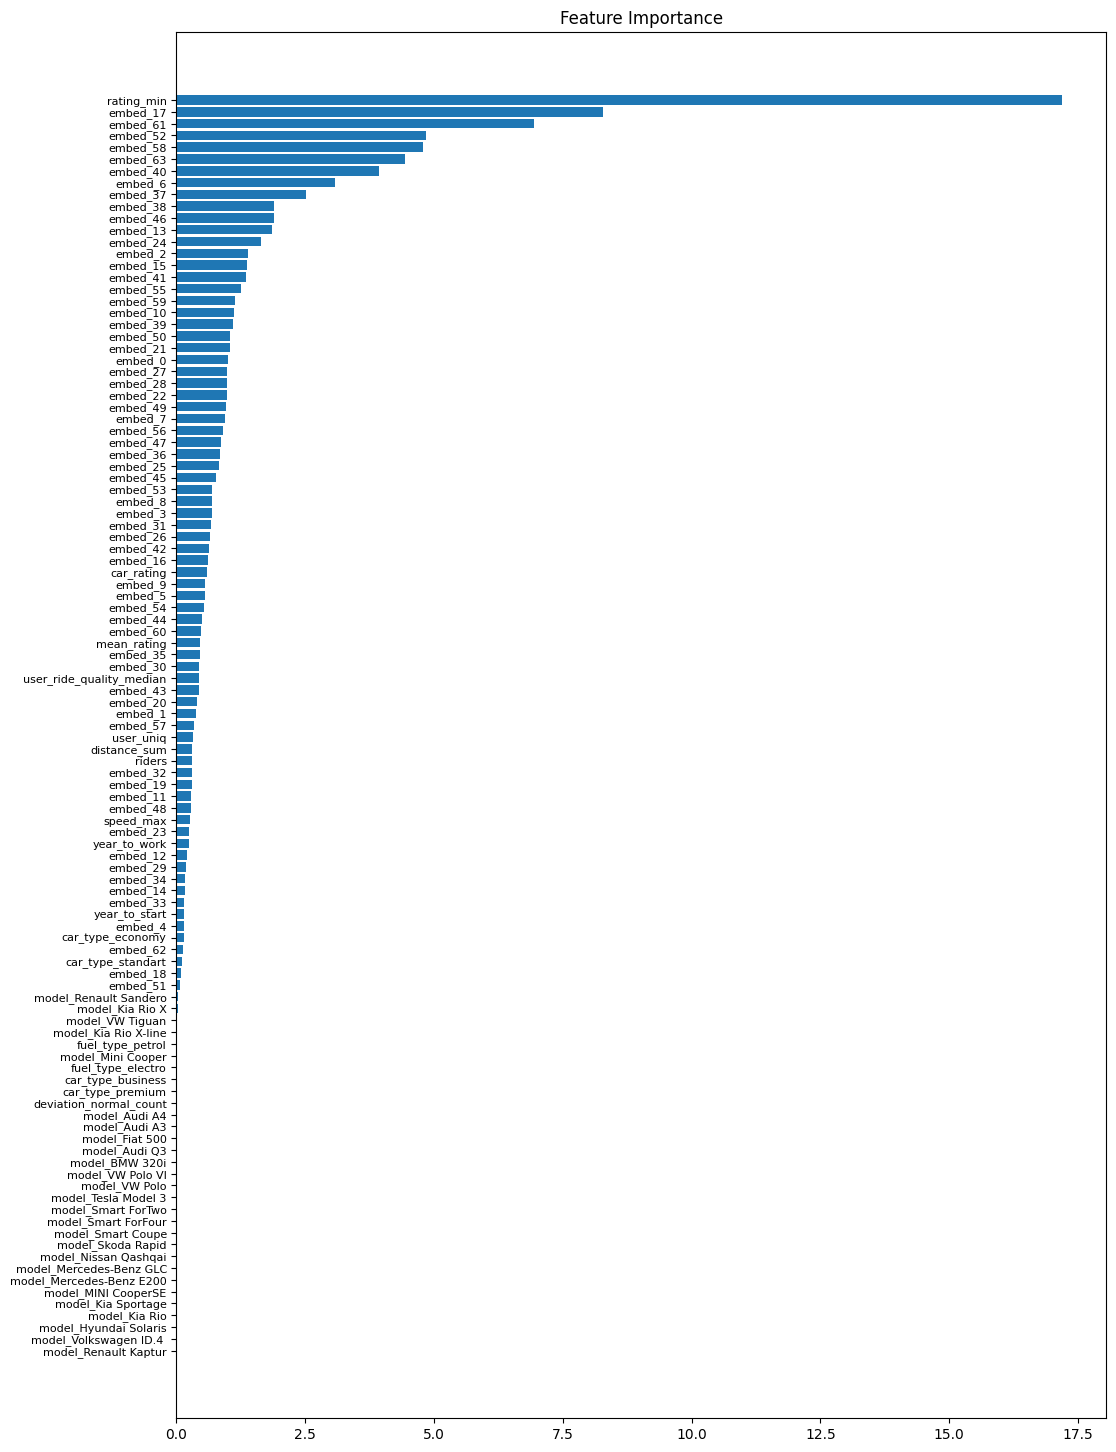

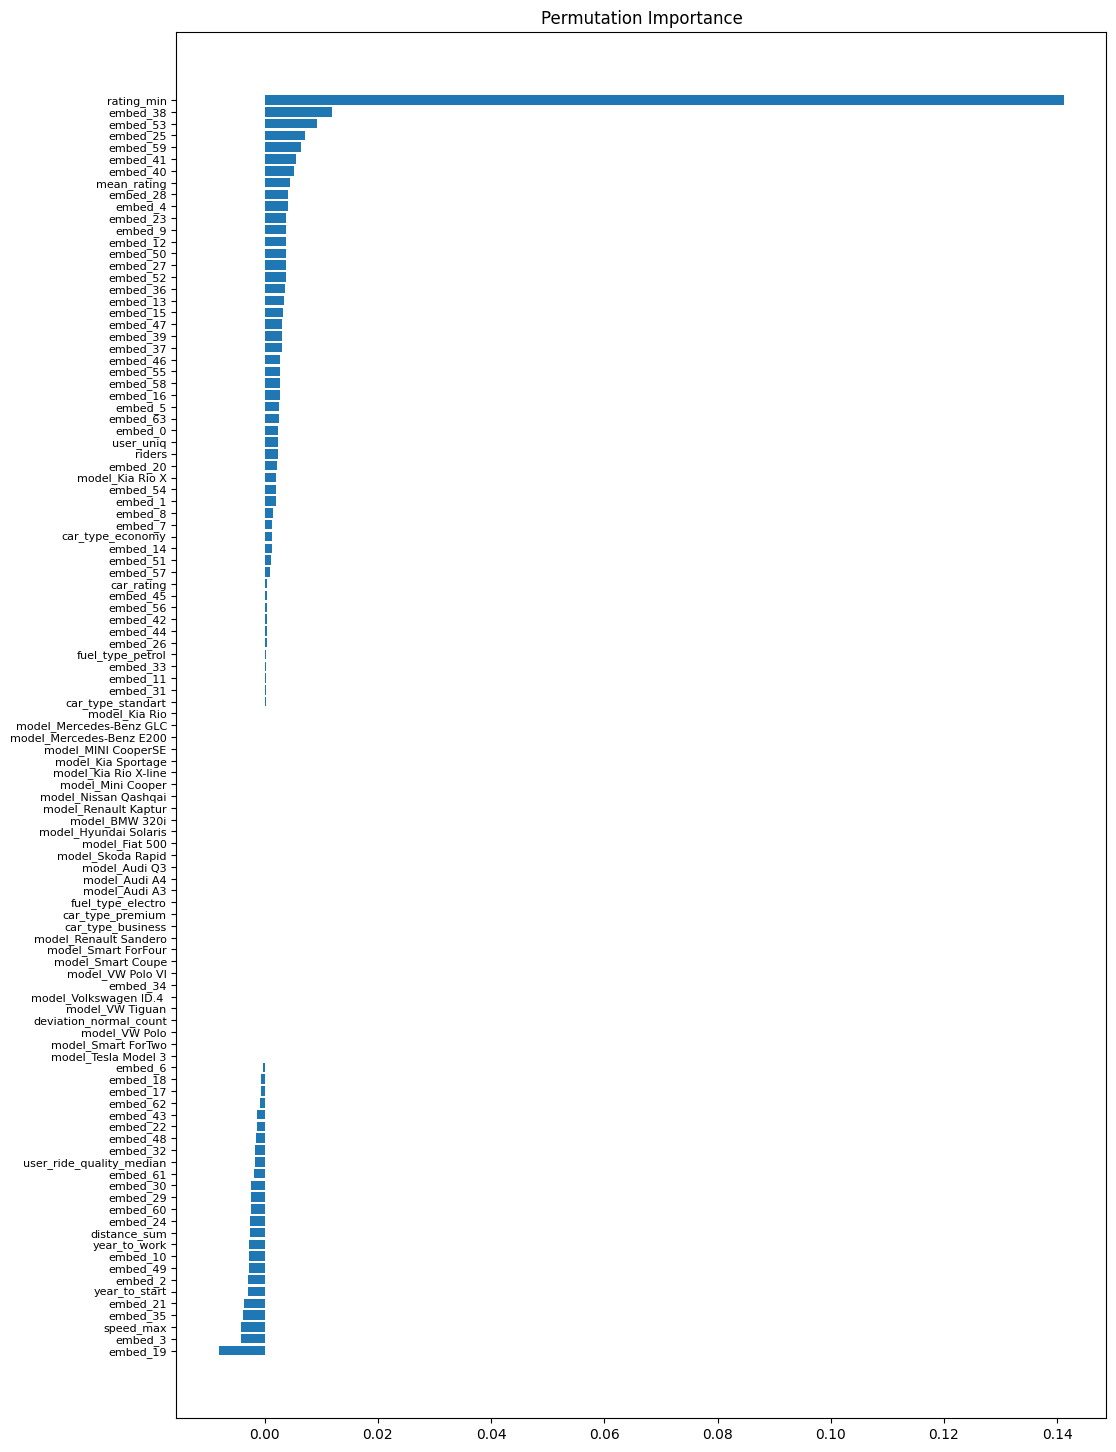

In [30]:
import matplotlib.pyplot as plt

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 18))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.title('Feature Importance');

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 18))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.title('Permutation Importance');

### Как видно, из графиков эмбеддинги являются сильными признаками

In [31]:
preds = clf.predict(X_test)
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)

(0.7881631148357173, 0.7841880341880342)

Скор модели, обученной на эмбеддингах выше, чем у нейросети

## Регрессия

In [32]:
X = df.drop(['target_reg','target_class'], axis=1)
y = df['target_reg']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
reg = CatBoostRegressor(random_seed=9,
                        thread_count=-1,
                        use_best_model=True)

In [35]:
reg.fit( X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(reg.get_best_score())

Learning rate set to 0.056174
0:	learn: 0.7360732	test: 0.7693664	best: 0.7693664 (0)	total: 51.3ms	remaining: 51.2s
50:	learn: 0.4454685	test: 0.5407996	best: 0.5407996 (50)	total: 2.07s	remaining: 38.5s
100:	learn: 0.4092978	test: 0.5355128	best: 0.5353847 (99)	total: 4.11s	remaining: 36.6s
150:	learn: 0.3802241	test: 0.5355801	best: 0.5340674 (119)	total: 7.1s	remaining: 39.9s
200:	learn: 0.3531892	test: 0.5364780	best: 0.5340674 (119)	total: 9.77s	remaining: 38.9s
250:	learn: 0.3297012	test: 0.5393247	best: 0.5340674 (119)	total: 11.9s	remaining: 35.5s
300:	learn: 0.3097561	test: 0.5402185	best: 0.5340674 (119)	total: 14s	remaining: 32.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5340674096
bestIteration = 119

Shrink model to first 120 iterations.
{'learn': {'RMSE': 0.3030432728300781}, 'validation': {'RMSE': 0.534067409586651}}


In [36]:
# Посмотрим важность признаков
fi = reg.get_feature_importance(prettified=True)
fi[:30]

,Feature Id,Importances
0,embed_8,32.209961
1,rating_min,14.815739
2,embed_47,3.602035
3,embed_39,2.559545
4,embed_21,1.871441
5,embed_33,1.849830
6,embed_26,1.812708
7,embed_3,1.755123
8,embed_2,1.679091
9,embed_1,1.531215


In [37]:
preds = reg.predict(X_test)

In [38]:
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [39]:
mean_squared_error(y_test, preds) ** 0.5

46.09466025555262

<div class="alert alert-info">

Вернемся к итоговой таблице: видим, что эмбеддинги из нейросети поданные в `CatBoost` смогли превзойти точность самой нейросети в задаче классификации. Чтобы ещё увеличить точность можно потюнить гиперпараметры `CatBoost` или поэкспериментировать с размером эмбеддингов, меняя `hidden_size` или последний слой. Так же можно попробовать получать эмбеддинги с более раннего слоя нейронки или сразу со всех. Вариантов множество!

<center> <img src='https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/images/nn2.png'> </center>

## <center>🧠 Мысли и выводы</center>


<div class="alert alert-info">

* Эмбеддинги полученные из нейронной сети могут поднять скор бустинга выше, чем донорская сеть. Но не всегда!
* Если есть обученная нейросеть под вашу или похожую задачу - стоит попробовать достать из неё эмбеддинги и добавить их к другим фичам.
* Рабочий кейс: посмотреть паблик кернелы соревнования основанные на нейронках и попробовать достать оттуда эмбеддинги для бустингов.
    
В следующем уроке рассмотрим получение эмбеддингов для тектовых признаков из `BERT трансформера`.